In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-and-dog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23777%2F30378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T131433Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0ce7064a25802d3882bf4efc836e40fc6e824e872e734332ac6499f89fb03d7704edc91da88f552342062011998f640dc0646a173a5ed542b2c08df05c9cd3b4477d6ca3c7b84c41bde7c35dddc2b0a0092e5b9771f33d5b8b37e6fa6196eaefd129f4295a3805c637937cb93c5407fe05ccac375e9e7835a1eebd7c6c46e652225e1e3efddb4b19d75f7775cc7a275bc696a0923f0af12ad540d49237e42816bc8dca1633c8fb238ba670d58497c9845111c9366b03a7bf323f2ea23928cb7f7c30745f0b366d9b6fb6e175e95e6fe79e4d46b889415ac29d1f97c41a6572bbfc761be0472282d8d413a892f9528d2b7652db78d82426f79a020ab23338f96c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 228487605 bytes downloaded
Downloaded and uncompressed: cat-and-dog
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

training_set = datagen.flow_from_directory(
        "../input/cat-and-dog/training_set/training_set/",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )


Found 8005 images belonging to 2 classes.


In [5]:
datagen1 = ImageDataGenerator(rescale=1./255)

test_set = datagen1.flow_from_directory(
        "../input/cat-and-dog/test_set/test_set",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )

Found 2023 images belonging to 2 classes.


In [6]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

In [7]:
from tensorflow.keras.regularizers import l2

In [8]:
cnn = tf.keras.models.Sequential()

In [9]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

In [10]:
cnn.add(tf.keras.layers.Flatten())

In [11]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

In [12]:
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4195457 (16.00 MB)
Trainable params: 4195457 (16.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

In [15]:
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15
251/251 [==============================] - 45s 172ms/step - loss: 0.9506 - accuracy: 0.5609 - val_loss: 0.8306 - val_accuracy: 0.6555
Epoch 2/15
251/251 [==============================] - 45s 180ms/step - loss: 0.7883 - accuracy: 0.6292 - val_loss: 0.7954 - val_accuracy: 0.6777
Epoch 3/15
251/251 [==============================] - 44s 174ms/step - loss: 0.7162 - accuracy: 0.6638 - val_loss: 0.6764 - val_accuracy: 0.6985
Epoch 4/15
251/251 [==============================] - 43s 171ms/step - loss: 0.6934 - accuracy: 0.6752 - val_loss: 0.6711 - val_accuracy: 0.6752
Epoch 5/15
251/251 [==============================] - 44s 174ms/step - loss: 0.6550 - accuracy: 0.6956 - val_loss: 0.6645 - val_accuracy: 0.6733
Epoch 6/15
251/251 [==============================] - 42s 167ms/step - loss: 0.6457 - accuracy: 0.6992 - val_loss: 0.6576 - val_accuracy: 0.7212
Epoch 7/15
251/251 [==============================] - 45s 180ms/step - loss: 0.6196 - accuracy: 0.7077 - val_loss: 0.7381 - val_ac

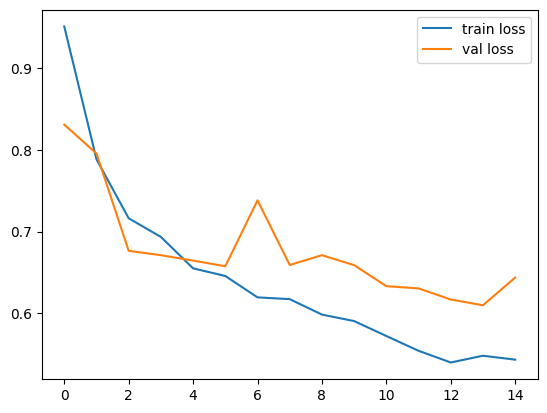

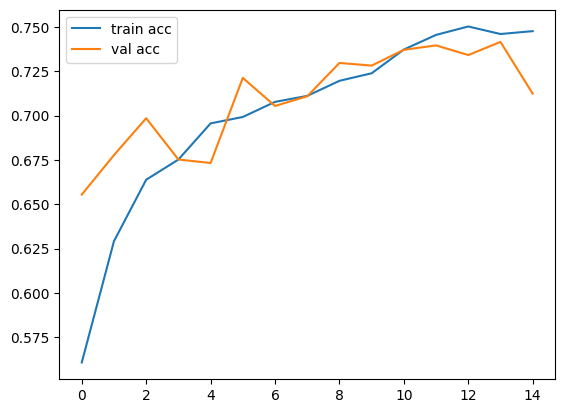

In [16]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [17]:
from tensorflow.keras.models import load_model

cnn.save('./model_rcat_dog.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
test_image = image.load_img('../input/cat-and-dog/training_set/training_set/dogs/dog.1023.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)

In [19]:
if result[0]<0:
    print("The image classified is cat")
else:
    print("The image classified is dog")

The image classified is dog
